In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = 'realdata' #"simdata"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [3]:
import torch
import shutil
import numpy as np
import pickle 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
import matplotlib.pyplot as plt
import re
import seaborn as sns
import hiplot as hip
import statsmodels

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian
from nnsysident.utility.measures import get_correlations

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

from nnsysident.datasets.mouse_loaders import static_loader

def find_number(text, c):
    number_list = re.findall(r'%s(\d+)' % c, text)
    if len(number_list) == 0:
        number = None
    elif len(number_list) == 1:
        number = int(number_list[0])
    else:
        raise ValueError('More than one number found..') 
    return number

def get_transfer(transfer_hashes):
    # prepare the Transfer table in a way that all the info about the transferred model is in the DataFrame. Just pd.merge (on transfer_fn and transfer_hash)
    # it then with the model that the transferred model was used for. 
    
    transfer = pd.DataFrame((Transfer & 'transfer_hash in {}'.format(tuple(transfer_hashes))).fetch())
    transfer = pd.concat([transfer, transfer['transfer_config'].apply(pd.Series)], axis = 1).drop('transfer_config', axis = 1)

    restriction = transfer.rename(columns = {'t_model_hash': 'model_hash', 't_dataset_hash': 'dataset_hash', 't_trainer_hash': 'trainer_hash'})            
    restriction = restriction[['model_hash', 'dataset_hash', 'trainer_hash']].to_dict('records')

    tm = pd.DataFrame((TrainedModel * Dataset * Seed & restriction).fetch()).rename(
        columns = {'model_hash': 't_model_hash', 'trainer_hash': 't_trainer_hash', 'dataset_hash': 't_dataset_hash'})               
    tm = tm.sort_values('score', ascending=False).drop_duplicates(['t_model_hash', 't_trainer_hash', 't_dataset_hash'])

    transfer = pd.merge(transfer, tm, how='inner', on=['t_model_hash', 't_trainer_hash', 't_dataset_hash'])
    transfer = pd.concat([transfer, transfer['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
    transfer.columns = ['t_' + col if col[:2] != 't_' and col[:8] != 'transfer'  else col for col in transfer.columns]
    transfer = transfer.sort_values(['t_multi_match_n', 't_image_n', 't_multi_match_base_seed', 't_image_base_seed'])
    return transfer


def get_transfer_entries(old_experiment_name, overall_best):
    tm = pd.DataFrame((TrainedModel * Dataset * Seed * Experiments.Restrictions & 'experiment_name="{}"'.format(old_experiment_name)).fetch())
    tm = pd.concat([tm, tm['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)

    model_fn = np.unique(tm['model_fn'])
    assert len(model_fn) == 1 ,"Must have exactly 1 model function in experiment"
    model_fn = model_fn[0] 

    # Filter out best model(s) 
    if overall_best is True:
        tm = tm.loc[(tm['multi_match_n'] == tm['multi_match_n'].max()) & (tm['image_n'] == tm['image_n'].max())]
    tm = tm.sort_values('score', ascending=False).drop_duplicates(['multi_match_n', 'image_n', 'multi_match_base_seed', 'image_base_seed']).sort_values(['multi_match_n', 'image_n'])

    # make entries for Trasfer table
    entries = [dict(transfer_fn='nnsysident.models.transfer_functions.core_transfer', 
                     transfer_config = dict(t_model_hash=row.model_hash, t_dataset_hash=row.dataset_hash, t_trainer_hash=row.trainer_hash),
                     transfer_comment=model_fn.split('.')[-1] + ', multi_match_n={}, multi_match_base_seed={}, image_n={}, image_base_seed={}'.format(row.multi_match_n, 
                                                                                                                                    row.multi_match_base_seed, 
                                                                                                                                    row.image_n, 
                                                                                                                                    row.image_base_seed),
                     transfer_fabrikant='kklurz') for loc, row in tm.iterrows()]
    return entries

Connecting konstantin@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306
Schema name: konstantin_nnsysident_realdata


In [4]:
# Get data
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (best), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (best from GAUSSIAN!), se2d_spatialxfeaturelinear, 4-set -> 4-set"]:
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})

In [5]:
model_fn = "nnsysident.models.models.se2d_fullgaussian2d"
my_data = data.loc[(data['# images'] == 200) & (data['multi_match_base_seed'] == 1) & (data['model_fn'] == model_fn)]
key = dict(model_fn=my_data.model_fn.values[0], 
           model_hash=my_data.model_hash.values[0],
           dataset_hash=my_data.dataset_hash.values[0], 
           trainer_hash = my_data.trainer_hash.values[0],
           transfer_hash = my_data.transfer_hash.values[0])
(TrainedModelTransfer & key)

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,transfer_fn name of the transfer function,transfer_hash hash of the configuration object,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
nnsysident.models.models.se2d_fullgaussian2d,b83116d0e8b7941cfca9b71df3bde94a,nnsysident.datasets.mouse_loaders.static_shared_loaders,7d3d23ebb1487f094fbcaf104e71fa14,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,1,nnsysident.models.transfer_functions.core_transfer,db3a0051f7b2f82c768f4ddc77d3f6ac,"detach_core=True.se2d_fullgaussian2d, multi_match_n=972, image_n=50.multi_match_n=972, image_n=50, exclude_multi_match_n=3625",0.0342784,=BLOB=,kklurz,2020-05-23 18:26:31


In [51]:
# define necessary stuff
from torch.nn import functional as F
from mlutils.measures import PoissonLoss
from tqdm import tqdm

def get_model(image_n):
    model_fn = "nnsysident.models.models.se2d_fullgaussian2d"
    my_data = data.loc[(data['# images'] == image_n) & (data['multi_match_base_seed'] == 1) & (data['model_fn'] == model_fn)]
    key = dict(model_fn=my_data.model_fn.values[0], 
           model_hash=my_data.model_hash.values[0],
           dataset_hash=my_data.dataset_hash.values[0], 
           trainer_hash = my_data.trainer_hash.values[0],
           transfer_hash = my_data.transfer_hash.values[0])
    key = (TrainedModelTransfer & key).proj().fetch1()
    dataloaders, model = TrainedModelTransfer().load_model(key=key)  
    model.cuda()
    model.eval()
    return model, dataloaders

def loss(model, data_key, neuron_idx, shift, target, core_out):
    x = model.readout[data_key](core_out, out_idx=neuron_idx, shift=shift)
    output = F.elu(x) + 1
    loss_scale = np.sqrt(len(dataloaders['train'][data_key].dataset) / core_out.shape[0])
    loss = loss_scale * criterion(output, target).detach().cpu().numpy()
    return loss

# This is the neuron we want to look at
neuron_idx = [569]
criterion = PoissonLoss(avg=False)
data_key = '22564-3-12-0'

# compute output of the core to images. Unfortunately have to break after some time because the memory isn't big enough for the whole thing
model, dataloaders = get_model(image_n=200) # 17596
core_outs = []
targets = []

# for i, (data_x, data_y) in enumerate(tqdm(dataloaders['train'][data_key])):
#     x = model.core(data_x)
#     core_outs.append(x)
#     targets.append(data_y)
#     break
    
for i, (data_x, data_y) in enumerate(tqdm(dataloaders['train'][data_key])):
    x = model.core(data_x).cpu().data.numpy()
    core_outs.append(x)
    targets.append(data_y.cpu().data.numpy())
#     break

data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00, 25.09it/s]


In [52]:
# torch.save(model.state_dict(), 'inshallahmodel.mojo')

In [53]:
core_outs = np.concatenate(core_outs)
targets = np.concatenate(targets).T
feature_weights = model.readout[data_key].features.squeeze().T.cpu().data.numpy()
biases = model.readout[data_key].bias.cpu().data.numpy()

In [54]:
core_outs.shape, targets.shape, feature_weights.shape, biases.shape

((50, 64, 22, 50), (978, 50), (978, 64), (978,))

In [9]:
def transform_spatial_scale(x_init, init_range, final_range):
    return (x_init - min(init_range)) * (max(final_range - min(final_range)) / max(init_range - min(init_range))) + min(final_range)

In [10]:
def elu1(val, alpha=1.):
    elued_val = val.copy()
    elued_val[elued_val<=0] = alpha * (np.exp(elued_val[elued_val<=0]) - 1)
    return elued_val + 1

In [11]:
def loss_fn(output, target, bias=1e-12, avg=False):
    loss = output - target * np.log(output + bias)
    return loss.mean() if avg else loss.sum(axis=(0, 1))

In [222]:
neuron_idx = 809

feature_weight_expanded = feature_weights[neuron_idx][None, :, None, None]
out = (feature_weight_expanded * core_outs).sum(axis=1, keepdims=True) + biases[neuron_idx]
out = elu1(out)
mask = loss_fn(out, targets[neuron_idx][:, None, None, None])

In [223]:
grid_y, grid_x = model.readout[data_key].mu.squeeze()[np.array(neuron_idx)].squeeze().detach().cpu().numpy()

In [224]:
feature_map_y, feature_map_x = transform_spatial_scale(grid_y, np.array([-1, 1]), np.array([0, 50])), transform_spatial_scale(grid_x, np.array([-1, 1]), np.array([0, 22]))
tx, ty = np.where(mask == mask.min())

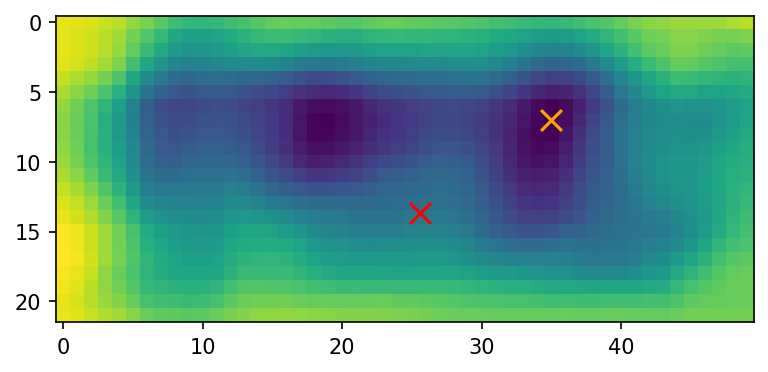

In [402]:
fig, ax = plt.subplots(dpi=150)
ax.imshow(mask)
ax.scatter(feature_map_y, feature_map_x, marker='x', color='r', s=100)
ax.scatter(ty, tx, marker='x', color='orange', s=100)

30.969355 38.163063
34.76891 40.299747
35.669487 43.1981
32.61497 38.60451


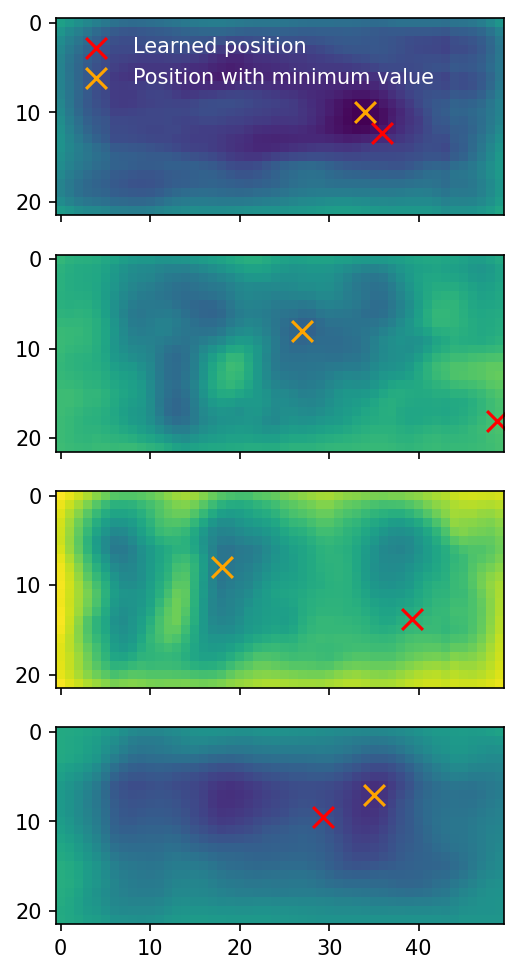

In [56]:
final_indices_raw = np.array([3511, 3105, 3036, 3751])
final_indices = final_indices_raw - (985 + 979 + 978)

fig, axes = plt.subplots(4, 1, dpi=150, figsize=(4, 8), sharex=True)

for ind, (neuron_idx, ax) in enumerate(zip(final_indices, axes)):
    feature_weight_expanded = feature_weights[neuron_idx][None, :, None, None]
    out = (feature_weight_expanded * core_outs).sum(axis=1, keepdims=True) + biases[neuron_idx]
    out = elu1(out)
    mask = loss_fn(out, targets[neuron_idx][:, None, None, None])
    
    grid_y, grid_x = model.readout[data_key].mu.squeeze()[np.array(neuron_idx)].squeeze().detach().cpu().numpy()
    
    feature_map_y, feature_map_x = transform_spatial_scale(grid_y, np.array([-1, 1]), np.array([0, 50])), transform_spatial_scale(grid_x, np.array([-1, 1]), np.array([0, 22]))
    tx, ty = np.where(mask == mask.min())
    
    print(mask.min(), mask.max())
    
    ax.imshow(mask, vmin=30.969355, vmax=43.1981)
    ax.scatter(feature_map_y, feature_map_x, marker='x', color='r', s=100, label='Learned position')
    ax.scatter(ty, tx, marker='x', color='orange', s=100, label='Position with minimum value')
    
    if ind == 0:
        leg = ax.legend(edgecolor="None", facecolor="None", loc="upper left")
        for text in leg.get_texts():
            text.set_color("white")

In [285]:
np.unique(data['# images'])

array([  200,   800,  2000,  4000, 10000, 17596])

In [386]:
model, dataloaders = get_model(image_n=200)

data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [13]:
grid = model.readout['22564-2-12-0'].grid.squeeze().cpu().data.numpy()

In [14]:
grid.shape

(985, 2)

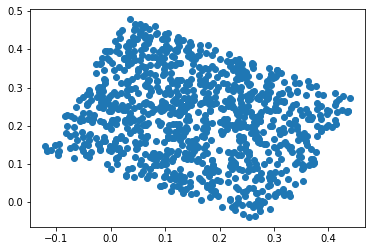

In [15]:
plt.scatter(*grid.T)

In [20]:
all_grids = []
for image_n, ax in zip(np.unique(data['# images']), axes.flat):
    model, dataloaders = get_model(image_n=image_n)
    grid = model.readout[data_key].grid.squeeze().cpu().data.numpy()
    all_grids.append(grid)

data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



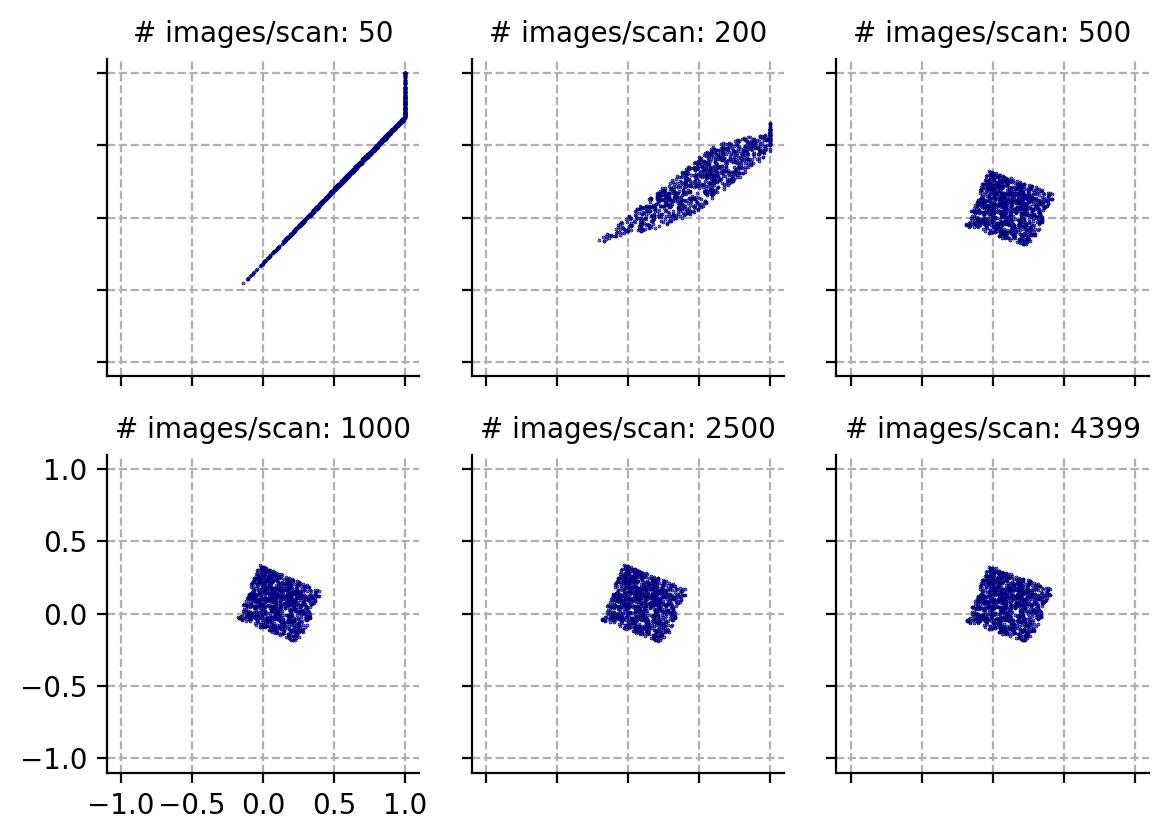

In [84]:
fig, axes = plt.subplots(2, len(np.unique(data['# images'])) // 2, dpi=200, figsize=(6, 4.3))
for ind, ax in enumerate(axes.flat):

    ax.scatter(*all_grids[ind].T, color='navy', s=.1, label='Learned position')
    ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
    sns.despine(top=True, ax=ax)
    
    ax.set(xticks=[-1, -.5, 0, .5, 1])
    ax.set_axisbelow(True)
    ax.grid(ls='--')
    if ind != 3:
        ax.set(xticklabels=[], yticklabels=[])
        
    ax.set_title(f"# images/scan: {np.unique(data['# images'])[ind] // 4}", fontsize=10)

fig.tight_layout()
fig.savefig("grids_sharedlim.pdf", bbox_inches='tight')

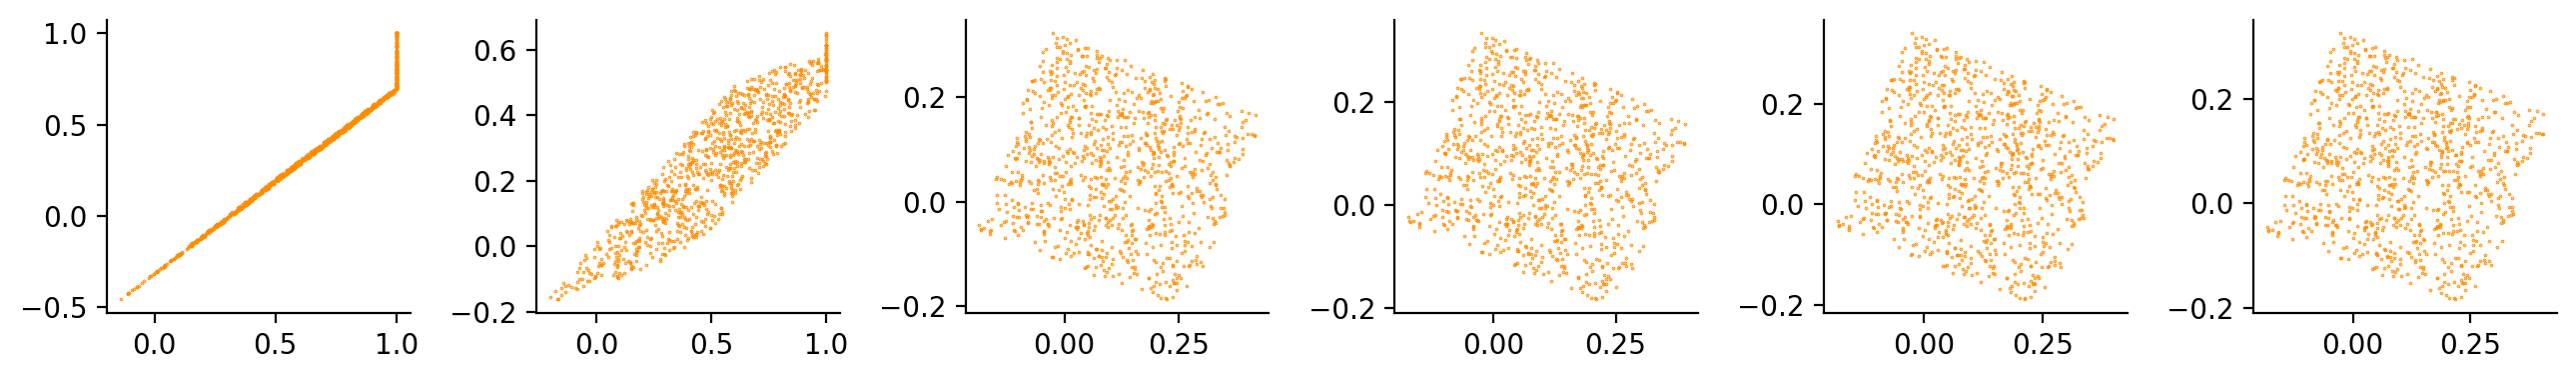

In [47]:
fig, axes = plt.subplots(1, len(np.unique(data['# images'])), dpi=200, figsize=(13, 2))
for ind, ax in enumerate(axes.flat):

    ax.scatter(*all_grids[ind].T, marker='o', color='darkorange', s=.1, label='Learned position')
#     ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
    sns.despine(top=True, ax=ax)
    
#     ax.set(xticks=[-1, -.5, 0, .5, 1])
#     if ind > 0:
#         ax.set(xticklabels=[], yticklabels=[])

fig.tight_layout()
fig.savefig("grids.pdf", bbox_inches='tight')

In [52]:
def transform_spatial_scale(x_init, init_range, final_range):
    return (x_init - min(init_range)) * (max(final_range - min(final_range)) / max(init_range - min(init_range))) + min(final_range)

In [81]:
transform_spatial_scale(0.16196062, np.array([-1, 1]), np.array([0, 50])), transform_spatial_scale(0.20249286, np.array([-1, 1]), np.array([0, 22]))

(29.049015499999996, 13.22742146)

In [95]:
mask = mask[7:-7, 15:-15]

In [96]:
mask.shape

(8, 20)

In [100]:
tx, ty = np.where(mask == mask.min())

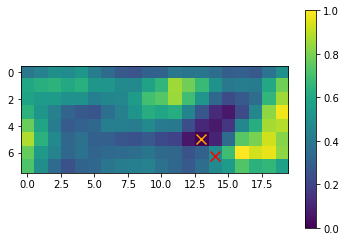

In [108]:
plt.imshow(mask)
plt.scatter(29.049015499999996-15, 13.22742146-7, marker='x', color='r', s=100)
plt.scatter(ty, tx, marker='x', color='orange', s=100)
plt.colorbar()

In [ ]:
np.where()

In [44]:
# feats = core_outs[0][1].cpu().data.numpy()
feats = core_outs[0].mean(dim=0).cpu().data.numpy()

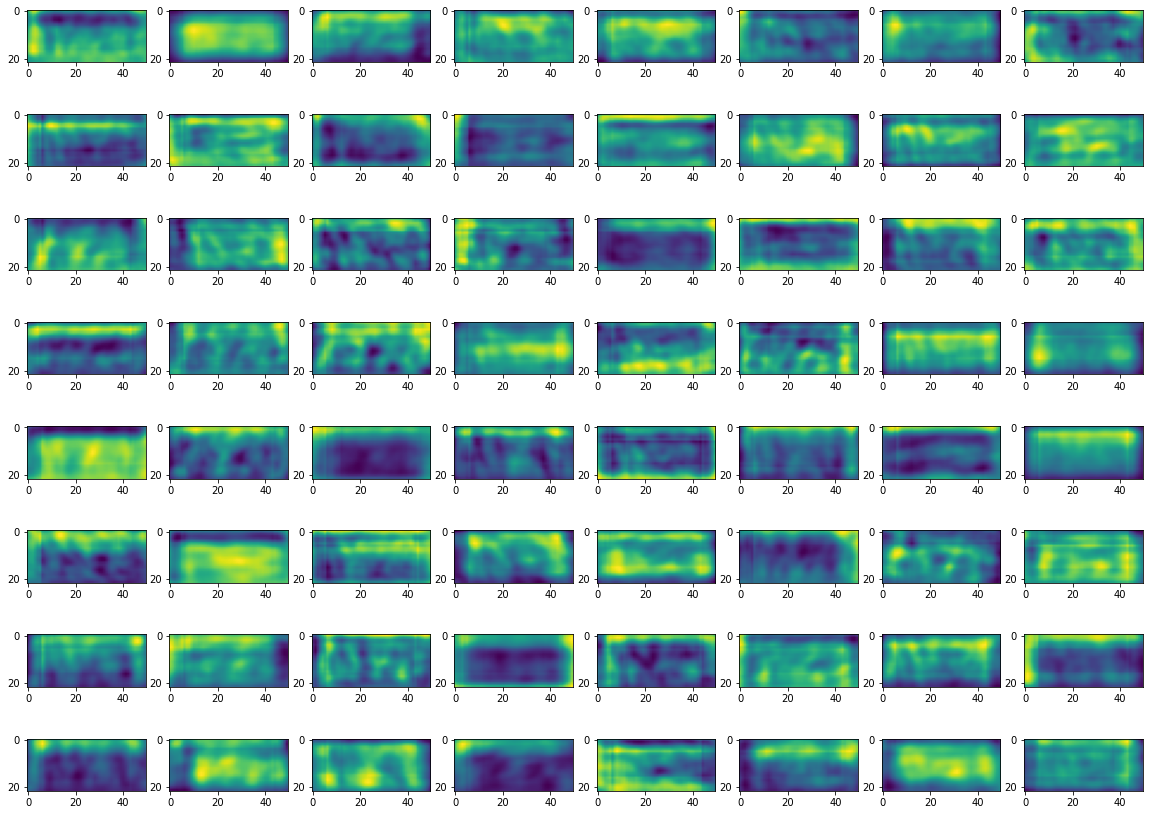

In [45]:
fig, axes = plt.subplots(8, 8, figsize=(20, 15))

for feat, ax in zip(feats, axes.flat):
    ax.imshow(feat)

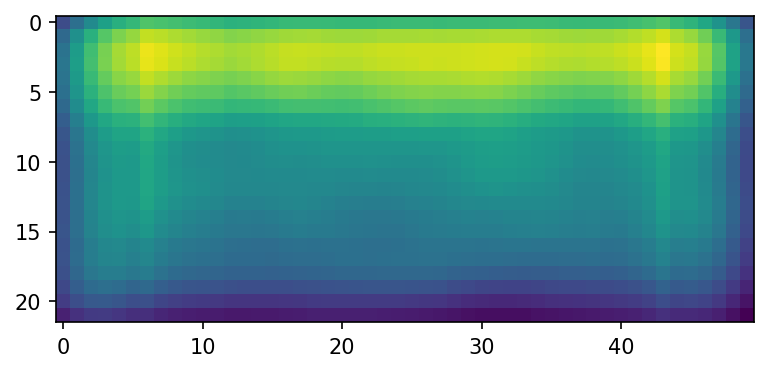

In [51]:
fig, ax = plt.subplots(dpi=150)
ax.imshow(feats.mean(axis=0));

In [291]:
model.readout['22564-2-12-0'].mu_transform[0].weight

Parameter containing:
tensor([[ 0.0824, -0.2223],
        [ 0.1824,  0.1124]], device='cuda:0', requires_grad=True)

In [292]:
from torch import nn

In [341]:
aa = nn.Linear(2, 2, bias=False)

In [347]:
aa.weight.data = torch.tensor([[0., -1.], 
                               [1., 0.]]) #, dtype=torch.float32)

In [348]:
aa.weight

Parameter containing:
tensor([[ 0., -1.],
        [ 1.,  0.]], requires_grad=True)

In [349]:
aa.bias

In [350]:
inp = torch.from_numpy(np.array([[2, 2]]).astype(np.float32))

In [351]:
aa(inp)

tensor([[-2.,  2.]], grad_fn=<MmBackward>)

In [371]:
model, dataloaders = get_model(image_n=200)

data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [377]:
ortho_lambda = .1
basis_ortho_reg = torch.mm(model.readout['22564-3-12-0'].mu_transform[0].weight[:, 0].view(1, -1), 
                           model.readout['22564-3-12-0'].mu_transform[0].weight[:, 1].view(1, -1).T).abs()

In [ ]:
ortho_lambda * basis_ortho_reg

In [367]:
A = model.readout['22564-3-12-0'].mu_transform[0].weight.cpu().data.numpy()

In [373]:
B = model.readout['22564-3-12-0'].mu_transform[0].weight.cpu().data.numpy()

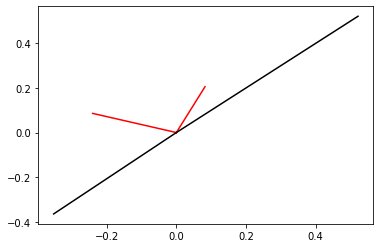

In [376]:
plt.plot([0, A[0, 0]], [0, A[1, 0]], 'r')
plt.plot([0, A[0, 1]], [0, A[1, 1]], 'r')
plt.plot([0, B[0, 0]], [0, B[1, 0]], 'k')
plt.plot([0, B[0, 1]], [0, B[1, 1]], 'k')